In [47]:
import networkx as nx
from helper import *
from collections import deque
import time

In [48]:
N = 7
p = 0.1
nodes_amplification = 3
G = nx.gnp_random_graph(N, p, directed=True)

In [49]:
VG = gen_voltage_digraph(G, "succ", [2,2,3,2,2,3,2])

In [ ]:
def labeled_cc_partition_refinement(N, rev_als):
    pi = [0] * N #equivalence
    C = [list(range(N))] #list of equivalence classes
    p = [0] #stack with the indices of the classes to evaluate
    its = 0

    while p:
        its += 1
        S = {} #sequences associated with each vertex, representing the class indices of its successor in significant class
        #L = []

        minr = N+1
        maxr = 0
        #We populate S
        while p: #there are remaining indices in p
            r = p.pop() #current class to evaluate
            minr = min(minr, r)
            maxr = max(maxr, r)

            for j in range(len(rev_als)):
                rev_al = rev_als[j]
                for v in C[r]:
                    for w in rev_al[v]:
                        if w not in S:
                            S[w] = []
                            #L.append(w)
                        S[w].append(r)

        LC = list(set([pi[v] for v in S.keys()])) #S.keys() is essentially L

        ni = {}
        for i in LC:
            ni[i] = 0
            for v in C[i]:
                if v in S:
                    ni[i] += 1

        k = max([len(S[v]) for v in S.keys()]) if S else 0 #max number of successors in significant class
        m = maxr - minr + 2 #ex. 0-5 -> void + [0,1,2,3,4,5] (7 classes)
        elements = deque(S.items())
        Q = [[] for _ in range(m)]
        for j in range(k,0,-1):
            while elements:
                A = elements.popleft()
                if len(A[1]) < j:
                    Q[0].append(A)
                else:
                    Q[A[1][j-1]-minr+1].append(A)
            for l in range(m):
                while Q[l]:
                    elements.extend(Q[l])
                    Q[l] = []
        S_sorted = list(elements)
        #S_sorted = sorted(S.items(), key=lambda item: item[1]) #SORT(L, S) with L = S.keys()
        L = [e[0] for e in S_sorted]

        T = {}
        R = {k: [] for k in LC}

        #We split equivalence class according to S
        while L:
            v = L.pop()
            i = pi[v]
            if ni[i] != 0: #True iff it's the first time we see class i
                T[i] = S[v]
                R[i].append(i)
                if ni[i] != len(C[i]): #Some vertices in C[i] have successors in non-significant class (the biggest, since index was not in p), so we need to split and add a new class
                    R[i].append(len(C))
                    C.append([])
                ni[i] = 0
            if T[i] != S[v]: #Every time we see a different sequence, we need further splitting
                T[i] = S[v]
                R[i].append(len(C))
                C.append([])
            S[v] = []

            #Move v to the new class (if created)
            r = R[i][-1]
            C[i].remove(v) #Seems inefficient. Not bad as it seems
            C[r].append(v)
            pi[v] = r


        #put classes in p for next round
        while LC:
            i = LC.pop()

            #significant classes are all except i
            for j in R[i]:
                if j != i:
                    p.append(j)

            #find the biggest subclass r and we exchange it with i if necessary
            r = R[i].pop()
            while R[i]:
                j = R[i].pop()
                if len(C[j])>len(C[r]):
                    r = j
            if r != i:
                for v in C[i]:
                    pi[v] = r
                for v in C[r]:
                    pi[v] = i
                C[i], C[r] = C[r], C[i]
    return pi, its

In [51]:
def cc_partition_refinement(G, eq_type="complete"):
    if isinstance(G, nx.DiGraph):
        if eq_type == "succ":
            rev_als = [gen_adj_list(G, reverse=True)]
        elif eq_type == "pred":
            rev_als = [gen_adj_list(G)]
        elif eq_type == "complete":
            rev_als = [gen_adj_list(G), gen_adj_list(G, reverse=True)]
        else:
            raise ValueError("eq_type must be either succ, pred or complete")
    elif isinstance(G, nx.Graph):
        rev_als = [gen_neighbourhood(G)]
    else:
        raise ValueError("Graph must be either DiGraph or Graph")
    return labeled_cc_partition_refinement(G.number_of_nodes(), rev_als)

In [52]:
VGs = gen_uniform_voltage_digraph(G, "succ", 3)
VGp = gen_uniform_voltage_digraph(G, "pred", 3)
VGstr = gen_strong_voltage_digraph(G, 3)

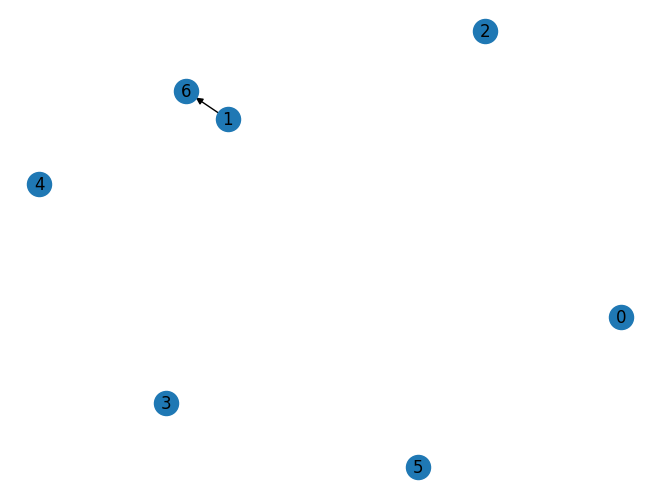

In [53]:
nx.draw(G, with_labels=True)

In [54]:
cc_partition_refinement(G)

([0, 1, 0, 0, 0, 0, 1], 2)

In [55]:
(cc_partition_refinement(VGs, eq_type="succ"),
cc_partition_refinement(VGs, eq_type="pred"),
cc_partition_refinement(VGs))

(([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2),
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 2),
 ([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 2))

In [56]:
(cc_partition_refinement(VGp, eq_type="succ"),
cc_partition_refinement(VGp, eq_type="pred"),
cc_partition_refinement(VGp))

(([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2),
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 2),
 ([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 2))

In [57]:
(cc_partition_refinement(VGstr, eq_type="succ"),
cc_partition_refinement(VGstr, eq_type="pred"),
cc_partition_refinement(VGstr))

IndexError: list index out of range

In [ ]:
def could_be_isomorphic_cc(G0, G1):
    G = combine_graphs(G0, G1)
    pi = cc_partition_refinement(G)
    G0_certificate = sorted(pi[:G0.number_of_nodes()])
    G1_certificate = sorted(pi[G0.number_of_nodes():])
    return G0_certificate == G1_certificate

In [ ]:
def could_be_isomorphic_wl(G0, G1):
    return nx.weisfeiler_lehman_graph_hash(G0) == nx.weisfeiler_lehman_graph_hash(G1)

In [ ]:
def color_refinement(G):
    labels = {}
    glabels = {}
    for i in range(G.number_of_nodes()):
        glabels[i] = 0
    glabelsCount = 1
    newlabel = 1

    done = False
    while not done:
        glabelsNew = {}
        glabelsCountNew = 0
        for node in G.nodes():
            label = str(glabels[node])
            s2 = []
            for neighbor in G[node]:
                s2.append(glabels[neighbor])
            s2.sort()
            for i in range(len(s2)):
                label += "_" + str(s2[i])
            if not (label in labels):
                labels[label] = newlabel
                newlabel += 1
                glabelsCountNew += 1
            glabelsNew[node] = labels[label]
        if glabelsCount == glabelsCountNew:
            done = True
        else:
            glabelsCount = glabelsCountNew
            glabels = glabelsNew.copy()
    return glabels

In [ ]:
G = nx.gnp_random_graph(10, 0.5)
VG = gen_voltage_graph(G, 3)
VG2 = gen_voltage_graph(G, 3)
G2 = nx.gnp_random_graph(10, 0.5)
VG3 = gen_voltage_graph(G2, 3)

In [ ]:
could_be_isomorphic_cc(VG, VG2), could_be_isomorphic_wl(VG, VG2)

In [ ]:
could_be_isomorphic_cc(VG, VG), could_be_isomorphic_wl(VG, VG)

In [ ]:
could_be_isomorphic_cc(VG, VG3), could_be_isomorphic_wl(VG, VG3)

In [ ]:
nodes = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000] #, 100000, 200000
density = 0.4 #Could try with 1/sqrt(n)
replicas = 5

In [ ]:
records = {}
for n in nodes:
    print("Nodes: ", n)
    print("Generating graph", end="")
    t1  = time.time()
    G = nx.gnp_random_graph(n, density)
    t2 = time.time()
    print(" - generated in ", t2-t1)
    print("Generating voltage graph", end="")
    t1 = time.time()
    VG = gen_voltage_graph(G, replicas)
    t2 = time.time()
    print(" - generated in ", t2-t1)

    results = []

    print("Executing CC", end="")
    rev_als = [gen_neighbourhood(G)]
    t1 = time.time()
    (_, its) = labeled_cc_partition_refinement(G.number_of_nodes(), rev_als)
    t2 = time.time()
    print(" - done in ", t2-t1)
    results.append(t2-t1)

    print("Executing WL...", end="")
    t1 = time.time()
    nx.weisfeiler_lehman_graph_hash(VG, iterations=its)
    t2 = time.time()
    print(" - done in ", t2-t1)
    results.append(t2-t1)

    print("Executing color refinement...", end="")
    t1 = time.time()
    color_refinement(VG)
    t2 = time.time()
    print(" - done in ", t2-t1)
    results.append(t2-t1)

    records[n] = results
    print(results)
    print()